In [20]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F

## Задание 4

In [3]:
# Генерация шума
def add_noise(img, noise_type="uniform", intensity=0.1):
    """
    noise_type: 'uniform' / 'non_uniform'.
    intensity: интенсивность шума [0, 1].
    """
    noisy_img = img.copy()
    if noise_type == "uniform":
        noise = np.random.uniform(0, 255, img.shape) * intensity
    elif noise_type == "non_uniform":
        noise = np.random.normal(0, 255 * intensity, img.shape)
    else:
        raise ValueError("Недопустимый тип шума")

    noisy_img = cv2.add(noisy_img, noise.astype(np.uint8))
    return noisy_img

In [15]:
import matplotlib.pyplot as plt

In [18]:
def load_images(image_paths, resize_shape=(32, 32), color_mode=cv2.IMREAD_GRAYSCALE):
    images = []
    for path in image_paths:
        img = cv2.imread(path, color_mode)
        if img is not None:
            img = cv2.resize(img, resize_shape)
            images.append(img.flatten())
            plt.imshow(cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB))
            plt.title(f'image loaded')
            plt.axis('off')
            plt.show()
    return np.array(images)

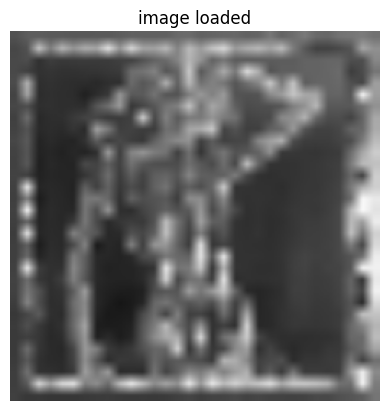

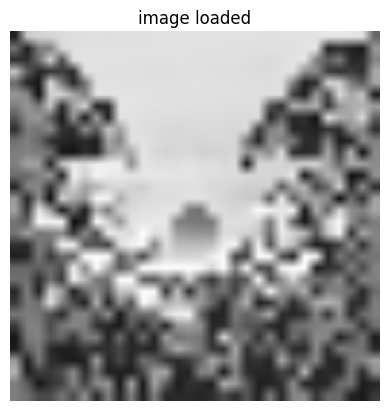

k=1, norm=euclidean: Uniform Noise Accuracy = 1.00, Non-uniform Noise Accuracy = 1.00
k=1, norm=manhattan: Uniform Noise Accuracy = 1.00, Non-uniform Noise Accuracy = 1.00
k=3, norm=euclidean: Uniform Noise Accuracy = 1.00, Non-uniform Noise Accuracy = 1.00
k=3, norm=manhattan: Uniform Noise Accuracy = 1.00, Non-uniform Noise Accuracy = 1.00
k=5, norm=euclidean: Uniform Noise Accuracy = 0.40, Non-uniform Noise Accuracy = 0.40
k=5, norm=manhattan: Uniform Noise Accuracy = 0.40, Non-uniform Noise Accuracy = 0.40


In [19]:
def knn(X_train_uniform, X_test_uniform, X_train_non_uniform, X_test_non_uniform, y_train, y_test):
    k_values = [1, 3, 5]
    norms = ['euclidean', 'manhattan']

    for k in k_values:
        if k > len(X_train_uniform):
            print(f"k={k} is greater than the number of training samples. Skipping...")
            continue
        for norm in norms:
            knn = KNeighborsClassifier(n_neighbors=k, metric=norm)

            # для равномерного шума
            knn.fit(X_train_uniform, y_train)
            y_pred_uniform = knn.predict(X_test_uniform)
            uniform_acc = accuracy_score(y_test, y_pred_uniform)

            # для неравномерного шума
            knn.fit(X_train_non_uniform, y_train)
            y_pred_non_uniform = knn.predict(X_test_non_uniform)
            non_uniform_acc = accuracy_score(y_test, y_pred_non_uniform)

            print(f"k={k}, norm={norm}: Uniform Noise Accuracy = {uniform_acc:.2f}, Non-uniform Noise Accuracy = {non_uniform_acc:.2f}")


if __name__ == "__main__":
    image_paths = ["0056.jpg", "volni.jpg"]
    images = load_images(image_paths)

    noisy_images_uniform = np.array([add_noise(img, "uniform") for img in images]).reshape(len(images), -1)
    noisy_images_non_uniform = np.array([add_noise(img, "non_uniform") for img in images]).reshape(len(images), -1)

    if len(images) < 10:
        images = np.tile(images, (10 // len(images), 1))
        noisy_images_uniform = np.tile(noisy_images_uniform,
         (10 // len(noisy_images_uniform), 1))
        noisy_images_non_uniform = np.tile(noisy_images_non_uniform,
         (10 // len(noisy_images_non_uniform), 1))

    X_train_uniform, X_test_uniform, y_train, y_test = train_test_split(noisy_images_uniform, [0, 1] * (len(noisy_images_uniform) // 2),
                                                                        test_size=0.5, random_state=42)
    X_train_non_uniform, X_test_non_uniform, _, _ = train_test_split(noisy_images_non_uniform, [0, 1] * (len(noisy_images_non_uniform) // 2),
                                                                     test_size=0.5, random_state=42)

    knn(X_train_uniform, X_test_uniform, X_train_non_uniform, X_test_non_uniform, y_train, y_test)


## Задание 5

In [21]:
# Генерация случайных шумовых изображений для выбросов типа 0

def generate_outliers(num_samples=50, img_shape=(32, 32)):
    return np.random.randint(0, 256, (num_samples, *img_shape), dtype=np.uint8)

In [23]:
def odin_detection(model, data, epsilon=0.002, temperature=1000):
    """
    ODIN для обнаружения выбросов.

    model - нейронная сеть.
    data - данные для анализа.
    epsilon - коэффициент для добавления шума.
    temperature - коэффициент температурного масштабирования.
    """
    model.eval()
    data_tensor = torch.from_numpy(data).float()
    data_tensor.requires_grad = True

    outputs = model(data_tensor)
    outputs = outputs / temperature
    max_scores, _ = torch.max(F.softmax(outputs, dim=1), dim=1)
    return max_scores.detach().numpy()

In [25]:
def knn_odin(X_train, y_train, X_test, y_test):
  k_values = [1, 3]
  norms = ['euclidean', 'manhattan']

  for k in k_values:
      for norm in norms:
          knn = KNeighborsClassifier(n_neighbors=k, metric=norm)
          knn.fit(X_train, y_train)
          y_pred = knn.predict(X_test)
          accuracy = accuracy_score(y_test, y_pred)
          print(f"KNN (k={k}, norm={norm}) Accuracy: {accuracy:.2f}")

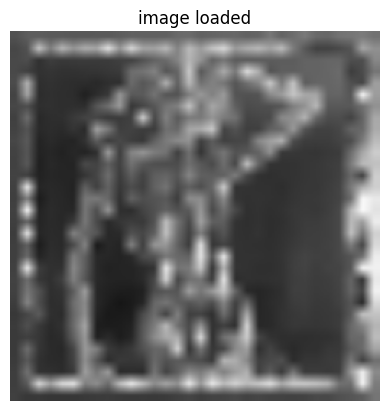

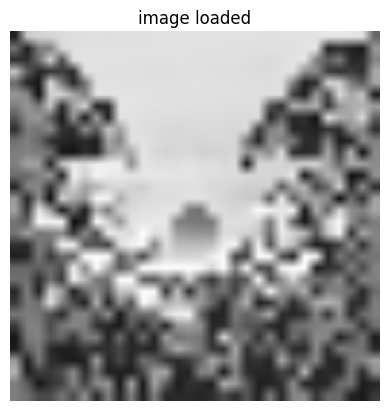

KNN (k=1, norm=euclidean) Accuracy: 0.67
KNN (k=1, norm=manhattan) Accuracy: 0.67
KNN (k=3, norm=euclidean) Accuracy: 0.67
KNN (k=3, norm=manhattan) Accuracy: 0.67
ODIN Scores: [0.5433929  0.5408864  0.53162247]


In [26]:
if __name__ == "__main__":
    image_paths = ["0056.jpg", "volni.jpg"]
    images = load_images(image_paths)

    # Генерация выбросов
    outliers = generate_outliers(num_samples=10)
    outliers_flat = outliers.reshape(len(outliers), -1)

    # Объединение данных для обучения
    combined_data = np.vstack((images, outliers_flat))
    combined_labels = np.array([0] * len(images) + [1] * len(outliers))  # 0 - обычные данные, 1 - выбросы

    X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

    knn_odin(X_train, y_train, X_test, y_test)

    # Использование метода ODIN для обнаружения выбросов
    # возьмем простую сверточную сеть
    model = torch.nn.Sequential(
        torch.nn.Linear(combined_data.shape[1], 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2)
    )

    # training модели
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Использование odin
    odin_scores = odin_detection(model, X_test)
    print("ODIN Scores:", odin_scores[:5])
